成功加载 33 个节点记录。


,node_id,parent_id,status,depth,lower_bound,gap,num_fractional_vars,branch_arc,branch_value
0,0,NaN,processed,0,-0.000031,-0.031250,18.0,None,NaN
1,1,0.0,processed,1,-0.000031,-0.031250,34.0,"[-1, 24]",0.0
2,2,0.0,processed,1,-0.000031,-0.026293,48.0,"[-1, 24]",1.0
3,3,1.0,processed,2,-0.000031,-0.031250,35.0,"[-1, 29]",0.0
4,4,1.0,pruned,2,-0.000025,0.196607,NaN,"[-1, 29]",1.0


正在生成树状图 (max_depth=None)...


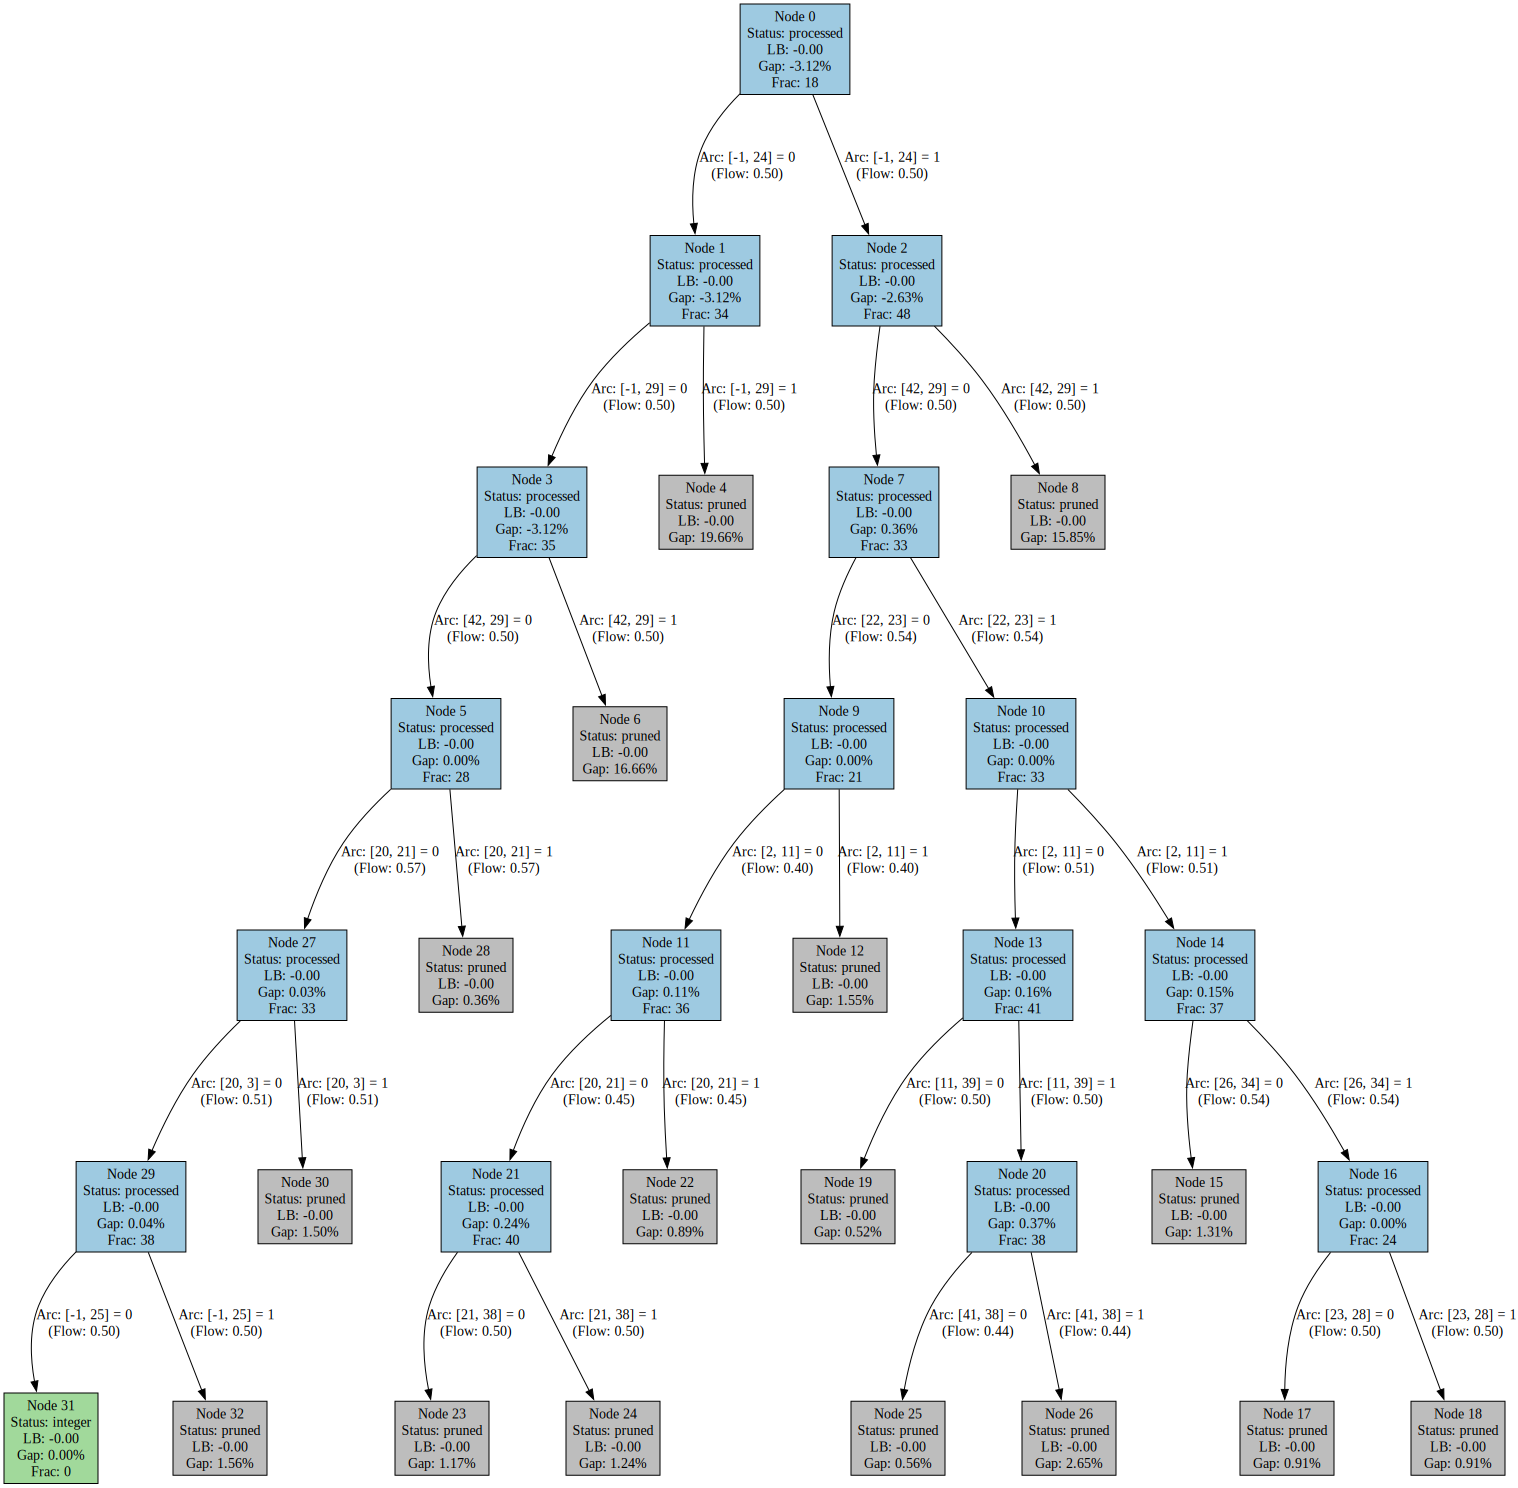


图像已保存到 ../logs/branch_tree_viz.png


In [ ]:
# %% [markdown]
# # Branch-and-Price Tree Visualization
# 
# This Notebook is used to load the `branch_tree.json` file and visualize it using the `graphviz` library.

# %%
import json
import pandas as pd
import graphviz
from typing import Dict, Any, Optional

# %% [markdown]
# ## 1. Load and Preview Data
# 
# First, we load the JSON file and convert it to a Pandas DataFrame for quick preview.

# %%
FILE_PATH = "../logs/branch_tree.json"

try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        node_records = json.load(f)
    print(f"Successfully loaded {len(node_records)} node records.")
except FileNotFoundError:
    print(f"Error: File {FILE_PATH} not found. Please ensure the path is correct.")
    node_records = {}
except json.JSONDecodeError:
    print(f"Error: File {FILE_PATH} is not a valid JSON.")
    node_records = {}

# %% [markdown]
# ### Preview Data (DataFrame)

# %%
if node_records:
    # Convert dictionary to DataFrame for easy viewing
    # We use orient='index' because the original JSON uses node_id as key
    df = pd.DataFrame.from_dict(node_records, orient='index')
    
    # Convert node_id from index to column and sort by integer
    df['node_id'] = df.index.astype(int)
    df = df.sort_values(by='node_id').reset_index(drop=True)
    
    # Display key columns
    display_cols = [
        'node_id', 'parent_id', 'status', 'depth', 
        'lower_bound', 'gap', 'num_fractional_vars', 
        'branch_arc', 'branch_value'
    ]
    display(df[display_cols].head())
else:
    print("No node data loaded.")

# %% [markdown]
# ## 2. Define Visualization Functions
# 
# We will create two functions:
# 1.  `_get_node_style`: A helper function that returns different colors and labels based on the node's status (e.g., 'integer', 'pruned').
# 2.  `plot_tree`: The main function that iterates through all nodes and edges to build the `graphviz` graph.

# %%
def _get_node_style(record: Dict[str, Any]) -> (str, str, str):
    """Return (label, color, fillcolor) based on node status."""
    
    status = record.get('status', 'pending')
    
    # 1. Set color
    if status == 'integer':
        fillcolor = '#a1d99b'  # Green (Integer solution)
    elif status == 'pruned':
        fillcolor = '#bdbdbd'  # Grey (Pruned)
    elif status == 'processed':
        fillcolor = '#9ecae1'  # Blue (Branched)
    elif status in ('infeasible', 'error'):
        fillcolor = '#fc9272'  # Red (Infeasible)
    elif status == 'pending':
        fillcolor = '#fee391'  # Yellow (Pending)
    else:
        fillcolor = 'white'
        
    color = 'black' # Border color
    
    # 2. Build label
    lb = record.get('lower_bound', float('inf'))
    gap = record.get('gap')
    
    label = f"Node {record['node_id']}\n"
    label += f"Status: {status}\n"
    label += f"LB: {lb:.2f}"
    
    if gap is not None:
        label += f"\nGap: {gap*100:.2f}%"
    
    if record.get('num_fractional_vars') is not None:
         label += f"\nFrac: {record['num_fractional_vars']}"

    return label, color, fillcolor

def plot_tree(records_dict: Dict[str, Dict[str, Any]], max_depth: Optional[int] = None) -> graphviz.Digraph:
    """
    Build and return a graphviz Digraph object using the node_records dictionary.
    
    Args:
        records_dict: Node records dictionary loaded from JSON.
        max_depth: Optional, limit the maximum depth of the tree to draw.
    """
    dot = graphviz.Digraph(comment='Branch and Price Tree')
    dot.attr(nodesep='1.0', ranksep='1.5') # Increase node spacing
    dot.attr('node', shape='box', style='filled')

    # 1. Add all nodes
    for node_id, record in records_dict.items():
        if max_depth is not None and record['depth'] > max_depth:
            continue
            
        label, color, fillcolor = _get_node_style(record)
        dot.node(
            name=str(node_id),  # graphviz name must be string
            label=label,
            color=color,
            fillcolor=fillcolor
        )

    # 2. Add all edges
    for node_id, record in records_dict.items():
        if max_depth is not None and record['depth'] > max_depth:
            continue
            
        parent_id = record.get('parent_id')
        
        # If not root node (parent_id exists)
        if parent_id is not None:
            parent_id_str = str(parent_id)
            
            # Check if parent node is also in dictionary (prevent max_depth truncation)
            if parent_id_str not in records_dict:
                continue

            # Build edge label
            arc = record.get('branch_arc')
            val = record.get('branch_value')
            flow = record.get('arc_flow_at_branch')
            
            if arc is not None and val is not None and flow is not None:
                edge_label = f"Arc: {arc} = {val}\n(Flow: {flow:.2f})"
            else:
                edge_label = "" # Root node branch
            
            dot.edge(
                parent_id_str,
                str(node_id),
                label=edge_label
            )
            
    return dot

# %% [markdown]
# ## 3. Generate and Display B&B Tree
# 
# Now we call the function to generate the graph.
# 
# **Note**: If the tree is very large (over 50 nodes), the image might become cluttered. You can set the `max_depth` parameter to show only the top few layers.

# %%
if node_records:
    # --- Set max depth here ---
    # Set to None to show the whole tree
    # Set to 3 or 4 for debugging
    VIZ_MAX_DEPTH = None 
    
    print(f"Generating tree graph (max_depth={VIZ_MAX_DEPTH})...")
    tree_graph = plot_tree(node_records, max_depth=VIZ_MAX_DEPTH)
    
    # Display directly in Notebook
    display(tree_graph)
    
    # (Optional) Save image to file
    try:
        # format='png' or 'svg'
        output_filename = FILE_PATH.replace('.json', '_viz')
        tree_graph.render(output_filename, format='png', view=False)
        print(f"\nImage saved to {output_filename}.png")
    except Exception as e:
        print(f"\nFailed to save image: {e}")
        print("This is usually because Graphviz executable is not installed or not in system PATH.")
        print("But the image can still be displayed in the Notebook.")

else:
    print("No data available for visualization.")

# %%